* In this notebook, there needs to be a plan for what to do with data from BIGRUN= the standard runs of ALMaSS of my thesis <br>
We are gonna start by:
* import relevant packages
* reading in the data and naming columns, making numeric if needed for BIGNU
* removing unneeded columns for dist_diff, het, pop_count, FST, FIS for BIGRUN


POP SIZES
* Then we are gonna calculate the effective pop size for each combi og rep, pop and landscape. (one number pr combi). For BIGRUN
* Also calculate census size pr subpop after 30 years

HETEROZYGOSITY
* Merge het loss dataset with pop size data set
* Calculate the expected het loss with those. - Show that the estimated effective pop sizes are inadequate.
* Estimate effective pop sizes from het loss. - Both the simple way (equation) AND the by finding slope as response pr year.
* Plot to see if any het loss trend for each version of a landscape.

FIS
* Merge with pop size estimate data set
* Filter FIS dataset to be only year 31
* Put a "landscape_id", a "div_type", and "div_dir" (division direction) into the df
* Plot FIS for each div_type and div_dir, all landscapes together.
* Plot FIS vs. pop size esitmate.

FST
* Filter FST dataset to be only year 31
* Put a "landscape_id", a "div_type", and "div_dir" (division direction) into the df
* Filter out all comparisons to itself
* Keep just one version of comparison of a pair of populations ex. just 0 to 1 and not but 0 to 1 and 1 to 0.
* Put an "opposite" column: did the two pops come from the same or opposite side of division, if any?
* Plot FIS for each div_type and div_dir, all landscapes together.


Dist+diff
* Classify all comparisons as either from the same or opposite side, or no div.
* Plot all landscapes together: x: distance, y: similarity, coulour by classification (same, opposite, no div)





____________________________________ <br>
## Prep data
We are gonna start by:
* import relevant packages &#x2611;
* reading in the data and naming columns for BIGRUN &#x2611;
* Remove rows that are obviously titles and make numeric if needed for BIGRUN &#x2611;
* removing unneeded columns for dist_diff, het, pop_count, FST, FIS for BIGRUN &#x2611;

### Import packages

In [34]:
import scipy
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import hmean

### Import data

In [35]:
#Het dataset -read it in, put column names
file_path = 'Heterozyg_mergedBIGRUN1.txt'
column_names=["year","pop","expected","observed","landscape","rep","landscape1","rep1"]
df_het=pd.read_csv(file_path, delimiter=',', header=None, names=column_names)

#Pop dataset -read it in, put column names
file_path = 'PopInQuad_mergedBIGRUN1.txt'
column_names = ["day",
                "quadrant0pop_males", "quadrant0pop_females",
                "quadrant1pop_males", "quadrant1pop_females",
                "quadrant2pop_males", "quadrant2pop_females",
                "quadrant3pop_males", "quadrant3pop_females",
                "excluded_males", "excluded_females",
                "sum_without_excluded_males", "sum_without_excluded_females",
                "sum_with_excluded_males", "sum_with_excluded_females",
                "sum_with_excluded_all", "sum_without_excluded_all",
                "division_direction","landscape","rep","landscape1","rep1"]
df_pop = pd.read_csv(file_path, delimiter=',', header=None, names=column_names)

#FIS dataset -read it in, put column names
column_namesFIS=["year","pop","FIS","division_direction","landscape","rep", "landscape1","rep1"]
df_FIS = pd.read_csv("FIS_mergedBIGRUN1.txt", delimiter=',', header=None, names=column_namesFIS)

#FST dataset -read it in, put column names
column_namesFST=["year","pop0","pop1","FST","division_direction","landscape","rep","landscape1","rep1"]
df_FST = pd.read_csv("FST_mergedBIGRUN1.txt", delimiter=',', header=None, names=column_namesFST)

#DistSimi dataset -read it in, put column names
column_names=["year","distance","pop0","pop1","similarity","div_dir","landscape","rep","landscape1","rep1"]
df_simi = pd.read_csv("DifferenceSimil_mergedBIGRUN1.txt", delimiter=',',low_memory=False, header=None, names=column_names)

 ### Transform numbers to numeric and remove any row that's actually a header of the data from a run

In [36]:
#Remove rows that are titles and filter out header lines
#het dataset

df_het=df_het[df_het['year']!='year'] #filtering out header line
numeric_columns=["year","pop","expected","observed"] 
df_het[numeric_columns]=df_het[numeric_columns].apply(pd.to_numeric, errors='coerce') #convert to numeric..

#same is done to the other datasets:

#pop dataset
df_pop=df_pop[df_pop['day']!='day']
numeric_columns=["day",
                "quadrant0pop_males", "quadrant0pop_females",
                "quadrant1pop_males", "quadrant1pop_females",
                "quadrant2pop_males", "quadrant2pop_females",
                "quadrant3pop_males", "quadrant3pop_females",
                "excluded_males", "excluded_females",
                "sum_without_excluded_males", "sum_without_excluded_females",
                "sum_with_excluded_males", "sum_with_excluded_females",
                "sum_with_excluded_all", "sum_without_excluded_all"]
df_pop[numeric_columns]=df_pop[numeric_columns].apply(pd.to_numeric, errors='coerce')


#FIS dataset
df_FIS=df_FIS[df_FIS['year']!='year']
numeric_columns=["year","pop","FIS"]
df_FIS[numeric_columns]=df_FIS[numeric_columns].apply(pd.to_numeric, errors='coerce')

#FST dataset
df_FST=df_FST[df_FST['year']!='year']
numeric_columns=["year","pop0","pop1","FST"]
df_FST[numeric_columns]=df_FST[numeric_columns].apply(pd.to_numeric, errors='coerce')

#Dist/simi dataset
df_simi=df_simi[df_simi['year']!='year']
numeric_columns=["year","distance","pop0","pop1","similarity"]
df_simi[numeric_columns]=df_simi[numeric_columns].apply(pd.to_numeric, errors='coerce')

### Remove unwanted/invalid columns

In [37]:
#remove unneeded/invalid columns
#het
df_het=df_het.drop(['landscape1', 'rep1'], axis=1)

#pop
df_pop=df_pop.drop(['landscape1', 'rep1','division_direction'], axis=1)

#FIS
df_FIS=df_FIS.drop(['landscape1', 'rep1','division_direction'], axis=1)

#FST
df_FST=df_FST.drop(['landscape1', 'rep1','division_direction'], axis=1)

#Dist/diff/simi
df_simi=df_simi.drop(['landscape1', 'rep1','div_dir'], axis=1)


________________<br>
## POP SIZES (effective)
* Calculate and plot average census size pr pop
* Then we are gonna calculate the effective pop size for each combi og rep, pop and landscape. (one number pr combi). &#x2611;

#### Census size + plotting it

In [38]:
import seaborn as sns
# grouping by 'landscape' and 'day' and calculating the mean of 'sum_with_excluded_all'
group_means = df_pop.groupby(['landscape', 'day'])['sum_with_excluded_all'].mean().reset_index()

# Rrnaming the column to indicate it's the mean
group_means = group_means.rename(columns={'sum_with_excluded_all': 'mean_census_for_landscape'})

# merging the group means back to the original DataFrame
df_pop = pd.merge(df_pop, group_means, on=['landscape', 'day'])

df_pop.head()


,day,quadrant0pop_males,quadrant0pop_females,quadrant1pop_males,quadrant1pop_females,quadrant2pop_males,quadrant2pop_females,quadrant3pop_males,quadrant3pop_females,excluded_males,excluded_females,sum_without_excluded_males,sum_without_excluded_females,sum_with_excluded_males,sum_with_excluded_females,sum_with_excluded_all,sum_without_excluded_all,landscape,rep,mean_census_for_landscape
0,1,1979,2047,2058,2064,1871,1800,1586,1548,1943,2033,7494,7459,9437,9492,18929,14953,LS01_amNS,rep_0,18930.0
1,8,1341,1490,1381,1447,1234,1251,1047,1187,1346,1501,5003,5375,6349,6876,13225,10378,LS01_amNS,rep_0,13204.1
2,15,925,1133,971,1091,861,947,709,964,960,1175,3466,4135,4426,5310,9736,7601,LS01_amNS,rep_0,9603.0
3,22,634,881,664,864,602,749,518,810,686,977,2418,3304,3104,4281,7385,5722,LS01_amNS,rep_0,7299.0
4,29,464,718,482,741,447,606,406,721,495,831,1799,2786,2294,3617,5911,4585,LS01_amNS,rep_0,5840.2


### Add descriptors to data to divide by

        day  quadrant0pop_males  quadrant0pop_females  quadrant1pop_males  \
1611  11308                2465                  4313                1905   
3223  11308                2147                  3994                2085   
4835  11308                2200                  4016                2241   
6447  11308                2523                  4521                1956   
8059  11308                2215                  3949                2072   

      quadrant1pop_females  quadrant2pop_males  quadrant2pop_females  \
1611                  3259                1778                  3150   
3223                  3696                1675                  2973   
4835                  3953                2037                  3711   
6447                  3533                1934                  3605   
8059                  3630                1679                  3028   

      quadrant3pop_males  quadrant3pop_females  excluded_males  ...  \
1611                4814         

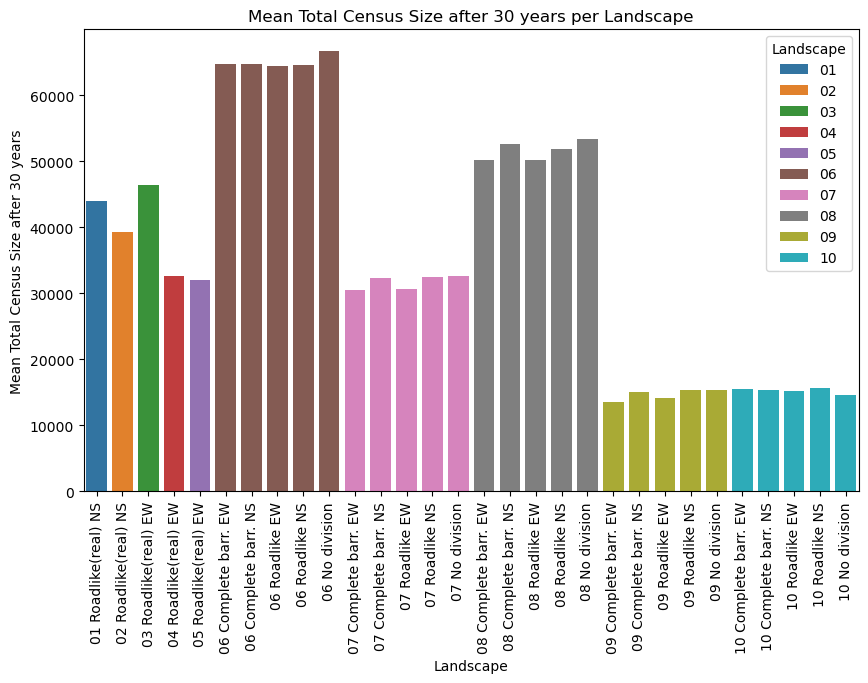

In [39]:
#To be able to meaningfully label the landscapes in human readable format, I make the "degree_of_div"-column and later a "nice label" col that has the type of division and landscape ID
degree_of_div_dict = {"nm": "No division", "frNS": "Roadlike NS", "fmNS": "Complete barr. NS","amNS":"Roadlike(real) NS","frEW": "Roadlike EW", "fmEW": "Complete barr. EW","amEW":"Roadlike(real) EW"}
df_pop['degree_of_div'] = df_pop['landscape'].str[5:].map(degree_of_div_dict)
df_pop['id_of_landscape'] = df_pop['landscape'].str.slice(2, 4)
df_pop['nice_labels'] = df_pop['id_of_landscape'] + " " + df_pop['degree_of_div']

#Filtering to only have data from the last observation: from the beginning om year 31 (aka after 30 years)
df_pop_end = df_pop[df_pop['day'] == 11308]


#have a look 
print(df_pop_end.head())

# Now for plotting the data
plt.figure(figsize=(10, 6))
sns.barplot(data=df_pop_end, x='nice_labels', y='mean_census_for_landscape', hue='id_of_landscape')

# Adding labels and title
plt.xlabel('Landscape')
plt.ylabel('Mean Total Census Size after 30 years')
plt.title('Mean Total Census Size after 30 years per Landscape')
plt.legend(title='Landscape')
#plt.grid(True)
plt.xticks(rotation=90)

# Show plot
plt.show()

### But the effective pop size is later calculated pr subpop, so we also need that for census size

In [40]:
#now let's do that but with average pr subpop instead!!


# Calculate total for each quadrant because males and females were counted seperately
df_pop['total_pop0'] = (df_pop['quadrant0pop_males'] + df_pop['quadrant0pop_females'])
df_pop['total_pop1'] = (df_pop['quadrant1pop_males'] + df_pop['quadrant1pop_females'])
df_pop['total_pop2'] = (df_pop['quadrant2pop_males'] + df_pop['quadrant2pop_females'])
df_pop['total_pop3'] = (df_pop['quadrant3pop_males'] + df_pop['quadrant3pop_females'])

import numpy as np

#calculte mean pr group of landscape, repeat, id of landscape
grouped_pop_counts_census = df_pop[df_pop['day']==11308].groupby(['landscape', 'rep', 'nice_labels','id_of_landscape']).agg({'total_pop0': lambda x: np.mean(x.dropna()),
                                                'total_pop1': lambda x: np.mean(x.dropna()),
                                                'total_pop2': lambda x: np.mean(x.dropna()),
                                                'total_pop3': lambda x: np.mean(x.dropna())})

# Reset index to make the grouped columns back to regular columns
grouped_pop_counts_census.reset_index(inplace=True)

#perform melting to give every oberservation its own row for ease of handeling!!
df_pop_census= grouped_pop_counts_census.melt(id_vars=['landscape', 'rep', 'nice_labels','id_of_landscape'], var_name='pop', value_name='total')
df_pop_census['pop'] = df_pop_census['pop'].str.extract(r'(\d+)').astype(int) #fix weird formatting problem

df_pop_census[df_pop_census['id_of_landscape']=='06'].tail() #have a look


,landscape,rep,nice_labels,id_of_landscape,pop,total
995,LS06_nm,rep_5,06 No division,06,3,17925.0
996,LS06_nm,rep_6,06 No division,06,3,17170.0
997,LS06_nm,rep_7,06 No division,06,3,16294.0
998,LS06_nm,rep_8,06 No division,06,3,17439.0
999,LS06_nm,rep_9,06 No division,06,3,17638.0


### Now plot the cencus size pr quadrant

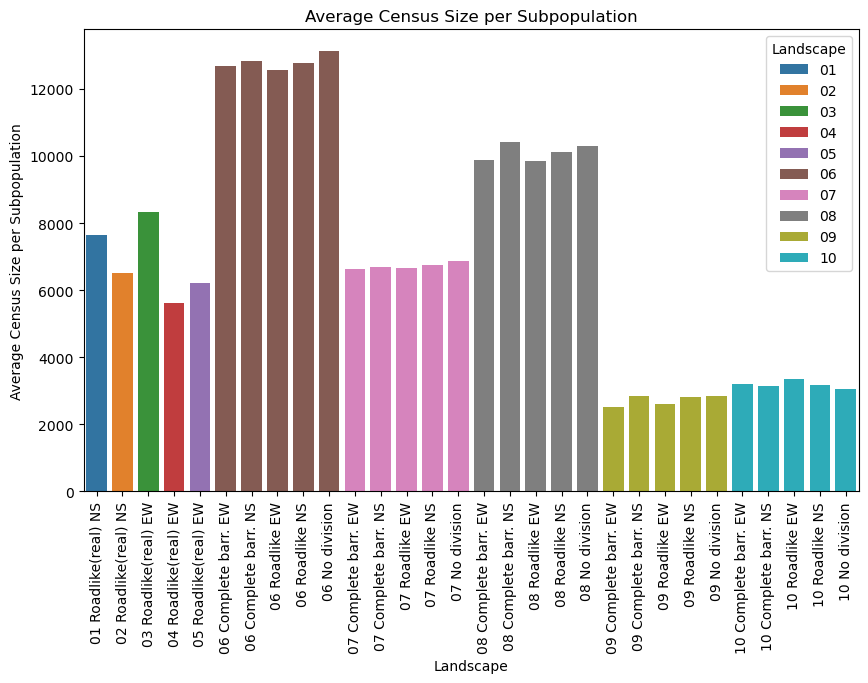

In [41]:
#group by nice label (landscape and division (for division ) type and by landscape (for colouring))
df_pop_census_groups = df_pop_census.groupby(['nice_labels','id_of_landscape'])['total'].mean().reset_index()

df_pop_census_groups['primary_sort_key'] = df_pop_census_groups['nice_labels'].str[:2]
df_pop_census_groups['secondary_sort_key'] = df_pop_census_groups['nice_labels'].str.endswith('No division')

# make sure "no division" is last in each category for consistency!!!
df_pop_census_groups = df_pop_census_groups.sort_values(
    by=['primary_sort_key', 'secondary_sort_key'],
    ascending=[True, True]
).drop(columns=['primary_sort_key', 'secondary_sort_key'])

# Plotting the sorted DataFrame
plt.figure(figsize=(10, 6)) # Create the figure here
sns.barplot(data=df_pop_census_groups, x='nice_labels', y='total', hue='id_of_landscape')
plt.xlabel('Landscape')
plt.legend(title='Landscape')
plt.ylabel('Average Census Size per Subpopulation')
plt.title('Average Census Size per Subpopulation')
plt.xticks(rotation=90)
plt.show()

### Calulate effective pop sizes for each pop in each diff run

In [42]:
#mf_corrected = male-female corrected
# Calculate mf_corrected_count_pop0, mf_corrected_count_pop1, mf_corrected_count_pop2, mf_corrected_count_pop3
df_pop['mf_corrected_count_pop0'] = (4 * df_pop['quadrant0pop_males'] * df_pop['quadrant0pop_females']) / (df_pop['quadrant0pop_males'] + df_pop['quadrant0pop_females'])
df_pop['mf_corrected_count_pop1'] = (4 * df_pop['quadrant1pop_males'] * df_pop['quadrant1pop_females']) / (df_pop['quadrant1pop_males'] + df_pop['quadrant1pop_females'])
df_pop['mf_corrected_count_pop2'] = (4 * df_pop['quadrant2pop_males'] * df_pop['quadrant2pop_females']) / (df_pop['quadrant2pop_males'] + df_pop['quadrant2pop_females'])
df_pop['mf_corrected_count_pop3'] = (4 * df_pop['quadrant3pop_males'] * df_pop['quadrant3pop_females']) / (df_pop['quadrant3pop_males'] + df_pop['quadrant3pop_females'])

# Group by "landscape" and "rep" columns and calculate the harmonic mean
grouped_pop_counts = df_pop.groupby(['landscape', 'rep', 'nice_labels','id_of_landscape']).agg({'mf_corrected_count_pop0': lambda x: hmean(x.dropna()),
                                                'mf_corrected_count_pop1': lambda x: hmean(x.dropna()),
                                                'mf_corrected_count_pop2': lambda x: hmean(x.dropna()),
                                                'mf_corrected_count_pop3': lambda x: hmean(x.dropna())})

# Reset index to make the grouped columns back to regular columns
grouped_pop_counts.reset_index(inplace=True)

#melt to give every observation its own column
df_pop_eff= grouped_pop_counts.melt(id_vars=['landscape', 'rep', 'nice_labels','id_of_landscape'], var_name='pop', value_name='mf_corrected_count')
df_pop_eff['pop'] = df_pop_eff['pop'].str.extract(r'(\d+)').astype(int) #fix formatting problem

df_pop_eff.head() #have a little look


,landscape,rep,nice_labels,id_of_landscape,pop,mf_corrected_count
0,LS01_amNS,rep_0,01 Roadlike(real) NS,01,0,4462.005247
1,LS01_amNS,rep_1,01 Roadlike(real) NS,01,0,3766.850674
2,LS01_amNS,rep_2,01 Roadlike(real) NS,01,0,4087.683393
3,LS01_amNS,rep_3,01 Roadlike(real) NS,01,0,3659.256897
4,LS01_amNS,rep_4,01 Roadlike(real) NS,01,0,3746.397715


### Plot it

<Figure size 1000x600 with 0 Axes>

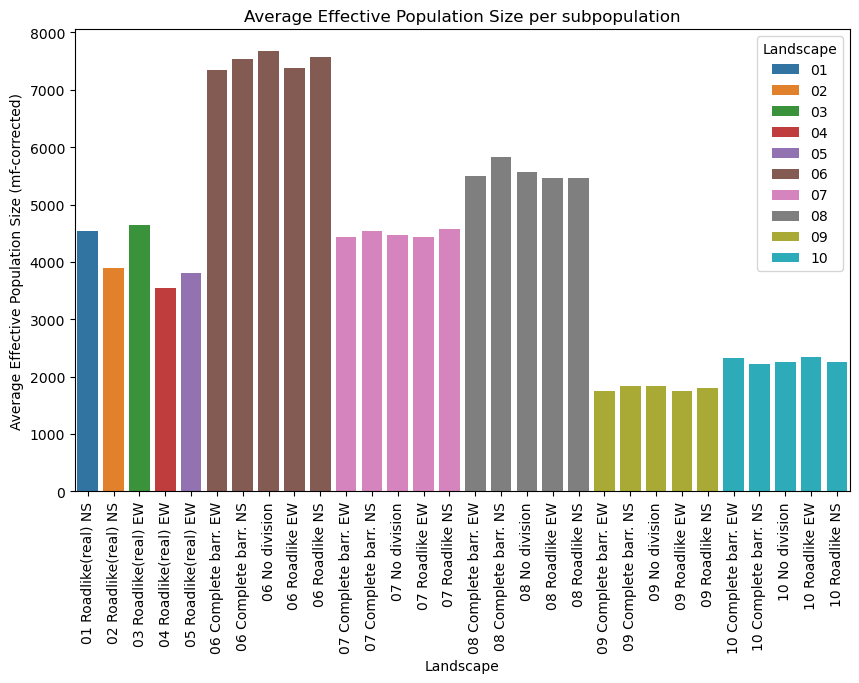

In [43]:
#group by nice label (landscape and division (for division ) type and by landscape (for colouring))
df_pop_eff_groups = df_pop_eff.groupby(['nice_labels','id_of_landscape'])['mf_corrected_count'].mean().reset_index()
df_pop_eff_groups.head()

plt.figure(figsize=(10, 6))


# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(data=df_pop_eff_groups, x='nice_labels', y='mf_corrected_count', hue='id_of_landscape')

# Adding labels and title
plt.xlabel('Landscape')
plt.ylabel('Average Effective Population Size (mf-corrected)')
plt.title('Average Effective Population Size per subpopulation')
plt.legend(title='Landscape')
plt.xticks(rotation=90)

# Show plot
plt.show()


___________
## HETEROZYGOSITY
* Merge het loss dataset with pop size &#x2611;
* Calculate the expected het loss with those. &#x2611;
* Show that the estimated effective pop sizes are inadequate. &#x2611;
* Estimate effective pop sizes from het loss. - Both the simple way (equation) &#x2611;
* Plot to see if any het loss trend for each version of a landscape. &#9744;  (could do more with this lol)

### Put effective pop size into het dataset

In [44]:
df_het = pd.merge(df_het, df_pop_eff[['landscape', 'pop', 'rep', 'mf_corrected_count']], on=['landscape', 'pop', 'rep'], how='left')

In [45]:
df_het.head()

,year,pop,expected,observed,landscape,rep,mf_corrected_count
0,1,0,0.245932,0.245642,LS01_amNS,rep_0,4462.005247
1,1,1,0.246025,0.245640,LS01_amNS,rep_0,3397.416585
2,1,2,0.246108,0.245698,LS01_amNS,rep_0,3083.118893
3,1,3,0.245314,0.244653,LS01_amNS,rep_0,8751.383714
4,2,0,0.244941,0.207857,LS01_amNS,rep_0,4462.005247


### Calculate expected heterozygosity frequency at each time point
#### With 1st year freq as starting point

With this equation:

$
het_{t}={(1 - 1/(2 N))}^{t}*{Het_{0}} 
$

In [46]:
#extract year 1 data
df_het_year1 = df_het[df_het['year'] == 1]
df_het_year1=df_het_year1.rename(columns={'observed': 'obs_starting_het1'})

print(df_het.head()) #have a little look
#merge the het from year 1 to the whole het dataframe
df_het = pd.merge(df_het, df_het_year1[['landscape', 'pop', 'rep', 'obs_starting_het1']], on=['landscape', 'pop', 'rep'], how='left')

#calulate the expected het after loss for each year. 2.5 gen pr year. 
df_het['expected_het_from_loss1'] = ((1 - (1 / (2 * df_het['mf_corrected_count']))) ** (2.5 * (df_het['year'] - 1)) * df_het['obs_starting_het1'])


   year  pop  expected  observed  landscape    rep  mf_corrected_count
0     1    0  0.245932  0.245642  LS01_amNS  rep_0         4462.005247
1     1    1  0.246025  0.245640  LS01_amNS  rep_0         3397.416585
2     1    2  0.246108  0.245698  LS01_amNS  rep_0         3083.118893
3     1    3  0.245314  0.244653  LS01_amNS  rep_0         8751.383714
4     2    0  0.244941  0.207857  LS01_amNS  rep_0         4462.005247


#### With 6th year het freq as starting point

In [47]:
#extract year 6 data
df_het_year6 = df_het[df_het['year'] == 6]
df_het_year6=df_het_year6.rename(columns={'observed': 'obs_starting_het6'})


#merge year 6 starting het to full df
df_het = pd.merge(df_het, df_het_year6[['landscape', 'pop', 'rep', 'obs_starting_het6']], on=['landscape', 'pop', 'rep'], how='left')


#calulate the expected het after loss for each year. 2.5 gen pr year.
df_het['expected_het_from_loss6'] = ((1 - (1 / (2 * df_het['mf_corrected_count']))) ** (2.5 * (df_het['year'] - 6)) * df_het['obs_starting_het6'])
df_het.tail()

,year,pop,expected,observed,landscape,rep,mf_corrected_count,obs_starting_het1,expected_het_from_loss1,obs_starting_het6,expected_het_from_loss6
37195,30,3,0.245381,0.125821,LS10_nm,rep_9,3212.056870,0.275327,0.272237,0.192580,0.190790
37196,31,0,0.249869,0.102868,LS10_nm,rep_9,1348.425343,0.273621,0.266115,0.175228,0.171213
37197,31,1,0.248243,0.130208,LS10_nm,rep_9,1216.065173,0.274043,0.265720,0.177411,0.172909
37198,31,2,0.258192,0.159327,LS10_nm,rep_9,3253.650776,0.274092,0.270951,0.200065,0.198153
37199,31,3,0.245411,0.129082,LS10_nm,rep_9,3212.056870,0.275327,0.272131,0.192580,0.190715


In [48]:
#make labelling for this dataset's plots like before
degree_of_div_dict = {"nm": "No division", "frNS": "Roadlike NS", "fmNS": "Complete barr. NS","amNS":"Roadlike(real) NS","frEW": "Roadlike EW", "fmEW": "Complete barr. EW","amEW":"Roadlike(real) EW"}
df_het['degree_of_div'] = df_het['landscape'].str[5:].map(degree_of_div_dict)
df_het['id_of_landscape'] = df_het['landscape'].str.slice(2, 4)
df_het['nice_labels'] = df_het['id_of_landscape'] + " " + df_het['degree_of_div']

#filter data to just be the het observed after 30 years
df_het_just31=df_het[df_het['year']==31]

df_het_just31.head()

,year,pop,expected,observed,landscape,rep,mf_corrected_count,obs_starting_het1,expected_het_from_loss1,obs_starting_het6,expected_het_from_loss6,degree_of_div,id_of_landscape,nice_labels
120,31,0,0.240695,0.159576,LS01_amNS,rep_0,4462.005247,0.245642,0.243586,0.175868,0.174641,Roadlike(real) NS,01,01 Roadlike(real) NS
121,31,1,0.228414,0.146925,LS01_amNS,rep_0,3397.416585,0.245640,0.242943,0.149356,0.147988,Roadlike(real) NS,01,01 Roadlike(real) NS
122,31,2,0.232252,0.116313,LS01_amNS,rep_0,3083.118893,0.245698,0.242727,0.151779,0.150248,Roadlike(real) NS,01,01 Roadlike(real) NS
123,31,3,0.230929,0.184191,LS01_amNS,rep_0,8751.383714,0.244653,0.243607,0.187751,0.187082,Roadlike(real) NS,01,01 Roadlike(real) NS
244,31,0,0.235725,0.143572,LS01_amNS,rep_1,3766.850674,0.254316,0.251797,0.156789,0.155494,Roadlike(real) NS,01,01 Roadlike(real) NS


### Now plot observed het, and the two estimates of observed het for year 31 (after 30 years)

/tmp/ipykernel_3502174/3446954373.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_het_just31['observed'] = pd.to_numeric(df_het_just31['observed'], errors='coerce')
/tmp/ipykernel_3502174/3446954373.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_het_just31['expected_het_from_loss1'] = pd.to_numeric(df_het_just31['expected_het_from_loss1'], errors='coerce')
/tmp/ipykernel_3502174/3446954373.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

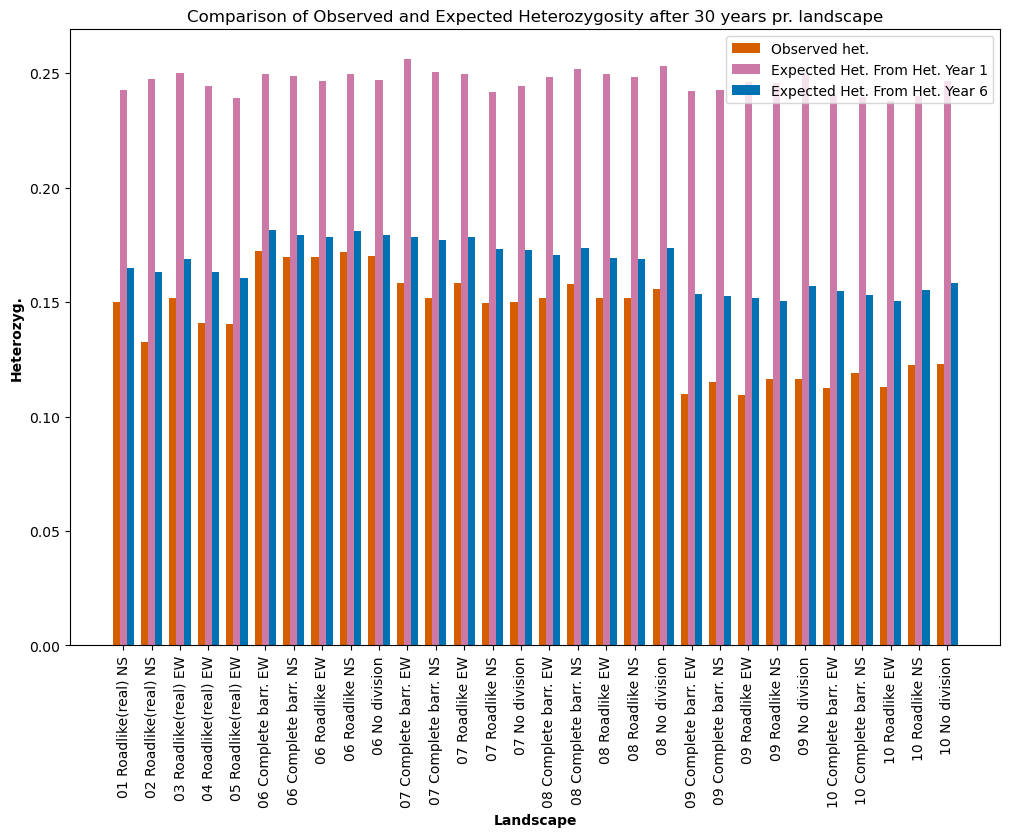

In [49]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure the necessary columns are numeric
df_het_just31['observed'] = pd.to_numeric(df_het_just31['observed'], errors='coerce')
df_het_just31['expected_het_from_loss1'] = pd.to_numeric(df_het_just31['expected_het_from_loss1'], errors='coerce')
df_het_just31['expected_het_fromloss6'] = pd.to_numeric(df_het_just31['expected_het_from_loss6'], errors='coerce')

# Group by 'landscape', and calculate the mean of each column
df_grouped = df_het_just31.groupby(['landscape','nice_labels']).mean(numeric_only=True).reset_index()

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))

# Define bar width and positions (enabeling all three columns right next to each other)
bar_width = 0.25
r1 = range(len(df_grouped))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Plot bars
ax.bar(r1, df_grouped['observed'], color='#d55e00', width=bar_width, label='Observed het.')
ax.bar(r2, df_grouped['expected_het_from_loss1'], color='#cc79a7', width=bar_width, label='Expected Het. From Het. Year 1')
ax.bar(r3, df_grouped['expected_het_fromloss6'], color='#0072b2', width=bar_width, label='Expected Het. From Het. Year 6')

# Add x labels and title
ax.set_xlabel('Landscape', fontweight='bold')
ax.set_ylabel('Heterozyg.', fontweight='bold')
ax.set_title('Comparison of Observed and Expected Heterozygosity after 30 years pr. landscape')

# Add xticks on the middle of the group bars
ax.set_xticks([r + bar_width for r in range(len(df_grouped))])
ax.set_xticklabels(df_grouped['nice_labels'], rotation=90)

# Add legend
ax.legend()

# Show plot
plt.show()


### Plot observed het (every year) pr landscape

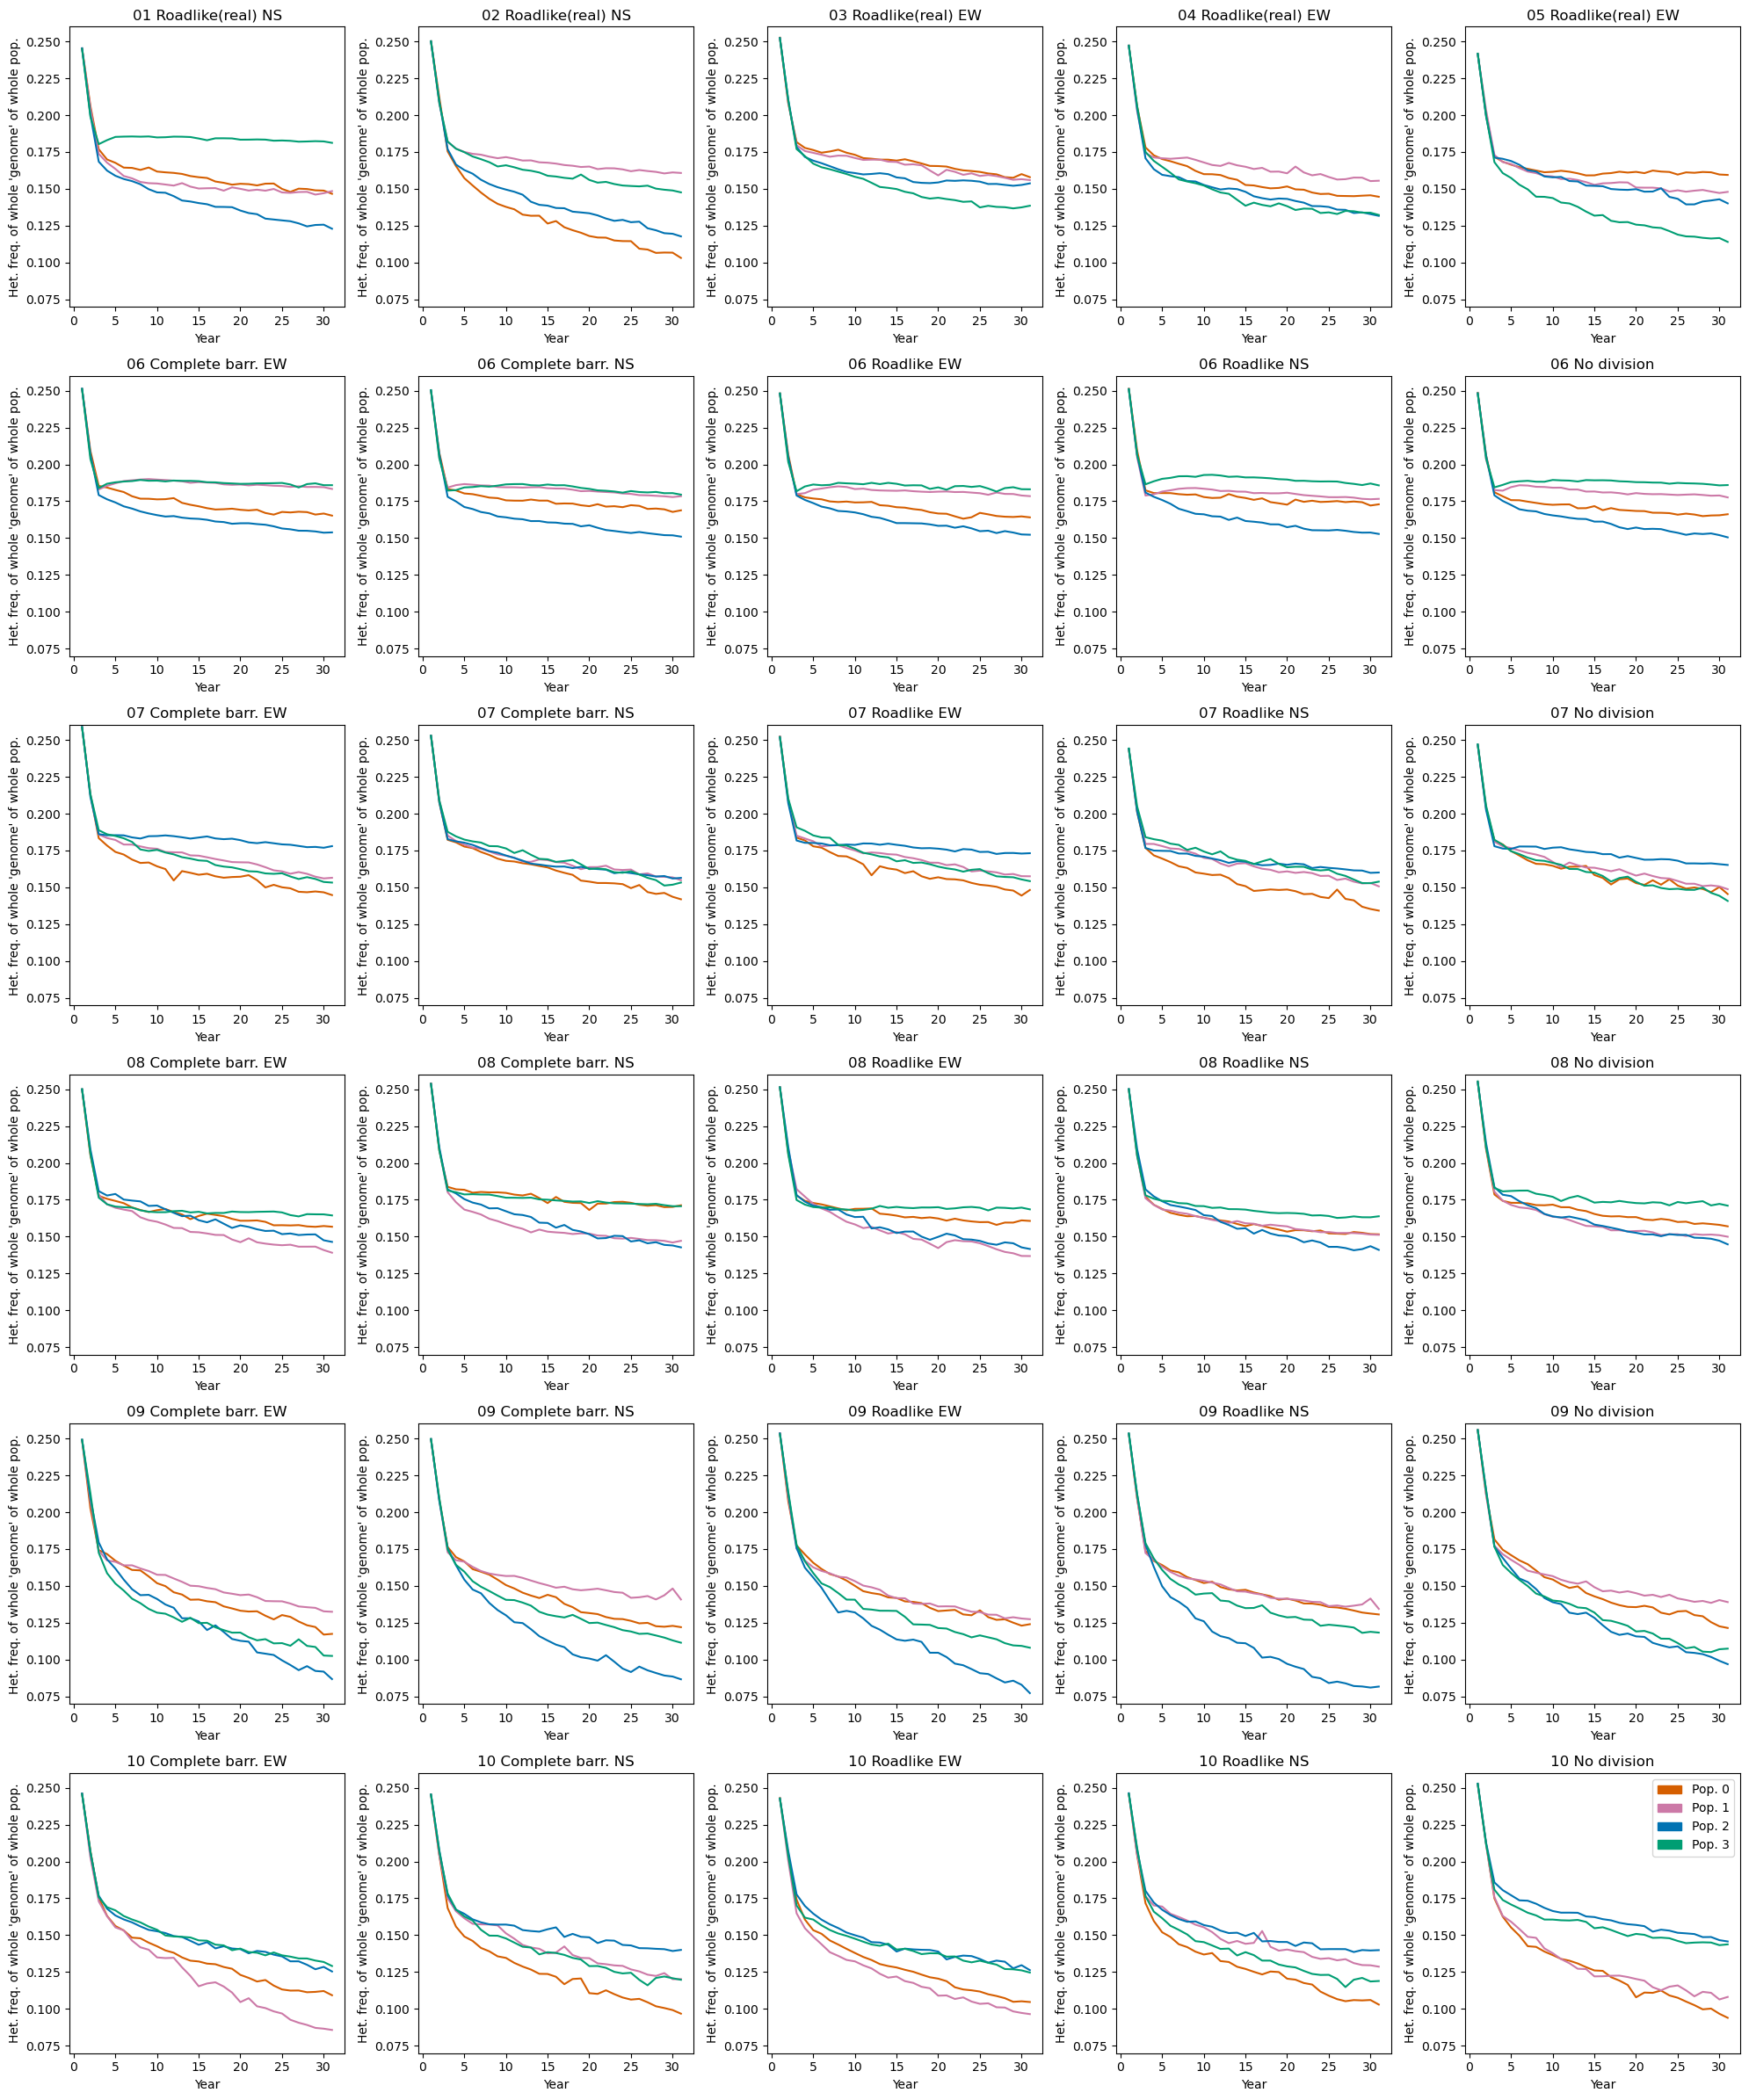

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches

#degree_of_div_dict = {"nm": "No division", "frNS": "Roadlike NS", "fmNS": "Complete barr. NS","amNS":"Roadlike(real) NS","frEW": "Roadlike EW", "fmEW": "Complete barr. EW","amEW":"Roadlike(real) EW"}
#df_het['degree_of_div'] = df_het['landscape'].str[5:].map(degree_of_div_dict)
#df_het['id_of_landscape'] = df_het['landscape'].str.slice(2, 4)
#df_het['nice_labels'] = df_het['id_of_landscape'] + " " + df_het['degree_of_div']



# Calculate means for each landscape, year, and population combination
means = df_het.groupby(['nice_labels', 'year', 'pop']).agg({'expected': 'mean', 'observed': 'mean', 'expected_het_from_loss1': 'mean', 'expected_het_from_loss6': 'mean'}).reset_index()

# put  number of rows and columns
num_plots = len(df_het['nice_labels'].unique())
num_rows = 6
num_cols = 5

# defining colours
colors = ['#d55e00', '#cc79a7', '#0072b2', '#009e73']

# Create a new figure with the desired layout
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 24))

# Flatten the axis array for easy iteration
axs = axs.flatten()

# Define legend handles and labels lists
line_handles = []
line_labels = []

# Iterate over unique landscapes (with div type and ID)
landscapes = df_het['nice_labels'].unique()
for i, landscape in enumerate(landscapes):
    # Filter DataFrame for the current landscape
    subset = means[means['nice_labels'] == landscape]
    
    # Get unique populations in the landscape
    populations = subset['pop'].unique()
    
    # Plot lines for each population
    for j, pop in enumerate(populations):
        pop_subset = subset[subset['pop'] == pop]
        color = colors[j % len(colors)]  
        # Plot lines and append legend handles and labels
        line, = axs[i].plot(pop_subset['year'], pop_subset['observed'], linestyle='-', color=color)
        line_handles.append(line)
        line_labels.append('Actual het. freq.')
        axs[i].set_ylim(0.07, 0.26)

    # Set labels and title
    axs[i].set_xlabel('Year')
    axs[i].set_ylabel('Het. freq. of whole \'genome\' of whole pop.')
    axs[i].set_title(f'{landscape}')

# Hide empty subplots
for j in range(num_plots, num_rows * num_cols):
    fig.delaxes(axs[j])

# Adjust layout
plt.tight_layout()

# Create legend colors
legend1 = plt.legend(handles=line_handles[:3], labels=line_labels[:3], loc='upper left', bbox_to_anchor=(0.4, 0.9))

#add legend of colours
color_patches = [
    mpatches.Patch(color='#d55e00', label='Pop. 0'),
    mpatches.Patch(color='#cc79a7', label='Pop. 1'),
    mpatches.Patch(color='#0072b2', label='Pop. 2'),
    mpatches.Patch(color='#009e73', label='Pop. 3')
]

# Create legend with the color patches because for some reason it does not happen automatically...
plt.legend(handles=color_patches)

# Show plot
plt.show()


### Estimate effective pop sizes from het loss. - The simple way (equation) (1st year obs as start)
We will use this equation: 
$$
N=-1/{(2((H_{t}/H_{0})^{1/t}-1))}
$$

In [51]:
# Calculate root_of_ratio
df_het['root_of_ratio_since_start'] = (df_het['observed'] / df_het['obs_starting_het1']) ** (1/(2.5*(df_het['year']-1)))

# Calculate pop_size_est_year_to_year
df_het['estimated_pop_size1'] = -1 / (2 * (df_het['root_of_ratio_since_start'] - 1))
df_het.tail()

,year,pop,expected,observed,landscape,rep,mf_corrected_count,obs_starting_het1,expected_het_from_loss1,obs_starting_het6,expected_het_from_loss6,degree_of_div,id_of_landscape,nice_labels,root_of_ratio_since_start,estimated_pop_size1
37195,30,3,0.245381,0.125821,LS10_nm,rep_9,3212.056870,0.275327,0.272237,0.192580,0.190790,No division,10,10 No division,0.989257,46.540881
37196,31,0,0.249869,0.102868,LS10_nm,rep_9,1348.425343,0.273621,0.266115,0.175228,0.171213,No division,10,10 No division,0.987041,38.582448
37197,31,1,0.248243,0.130208,LS10_nm,rep_9,1216.065173,0.274043,0.265720,0.177411,0.172909,No division,10,10 No division,0.990127,50.643354
37198,31,2,0.258192,0.159327,LS10_nm,rep_9,3253.650776,0.274092,0.270951,0.200065,0.198153,No division,10,10 No division,0.992793,69.374073
37199,31,3,0.245411,0.129082,LS10_nm,rep_9,3212.056870,0.275327,0.272131,0.192580,0.190715,No division,10,10 No division,0.989951,49.754612


#### Also try for year 6 starting freq

In [52]:
# Calculate root_of_ratio
df_het['root_of_ratio_since_start_at6'] = (df_het['observed'] / df_het['obs_starting_het6']) ** (1/(2.5*(df_het['year']-6)))



# Calculate pop_size_est_year_to_year
df_het['estimated_pop_size_start6'] = -1 / (2 * (df_het['root_of_ratio_since_start_at6'] - 1))
df_het

,year,pop,expected,observed,landscape,rep,mf_corrected_count,obs_starting_het1,expected_het_from_loss1,obs_starting_het6,expected_het_from_loss6,degree_of_div,id_of_landscape,nice_labels,root_of_ratio_since_start,estimated_pop_size1,root_of_ratio_since_start_at6,estimated_pop_size_start6
0,1,0,0.245932,0.245642,LS01_amNS,rep_0,4462.005247,0.245642,0.245642,0.175868,0.176115,Roadlike(real) NS,01,01 Roadlike(real) NS,1.000000,-inf,0.973623,18.955766
1,1,1,0.246025,0.245640,LS01_amNS,rep_0,3397.416585,0.245640,0.245640,0.149356,0.149631,Roadlike(real) NS,01,01 Roadlike(real) NS,1.000000,-inf,0.960979,12.813606
2,1,2,0.246108,0.245698,LS01_amNS,rep_0,3083.118893,0.245698,0.245698,0.151779,0.152087,Roadlike(real) NS,01,01 Roadlike(real) NS,1.000000,-inf,0.962199,13.227089
3,1,3,0.245314,0.244653,LS01_amNS,rep_0,8751.383714,0.244653,0.244653,0.187751,0.187885,Roadlike(real) NS,01,01 Roadlike(real) NS,1.000000,-inf,0.979045,23.860354
4,2,0,0.244941,0.207857,LS01_amNS,rep_0,4462.005247,0.245642,0.245573,0.175868,0.176065,Roadlike(real) NS,01,01 Roadlike(real) NS,0.935373,7.736700,0.983427,30.169921
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37195,30,3,0.245381,0.125821,LS10_nm,rep_9,3212.056870,0.275327,0.272237,0.192580,0.190790,No division,10,10 No division,0.989257,46.540881,0.992931,70.730507
37196,31,0,0.249869,0.102868,LS10_nm,rep_9,1348.425343,0.273621,0.266115,0.175228,0.171213,No division,10,10 No division,0.987041,38.582448,0.991514,58.920225
37197,31,1,0.248243,0.130208,LS10_nm,rep_9,1216.065173,0.274043,0.265720,0.177411,0.172909,No division,10,10 No division,0.990127,50.643354,0.995063,101.273074
37198,31,2,0.258192,0.159327,LS10_nm,rep_9,3253.650776,0.274092,0.270951,0.200065,0.198153,No division,10,10 No division,0.992793,69.374073,0.996364,137.502011


#### Now let's finally plot these eff. pop. size estimates

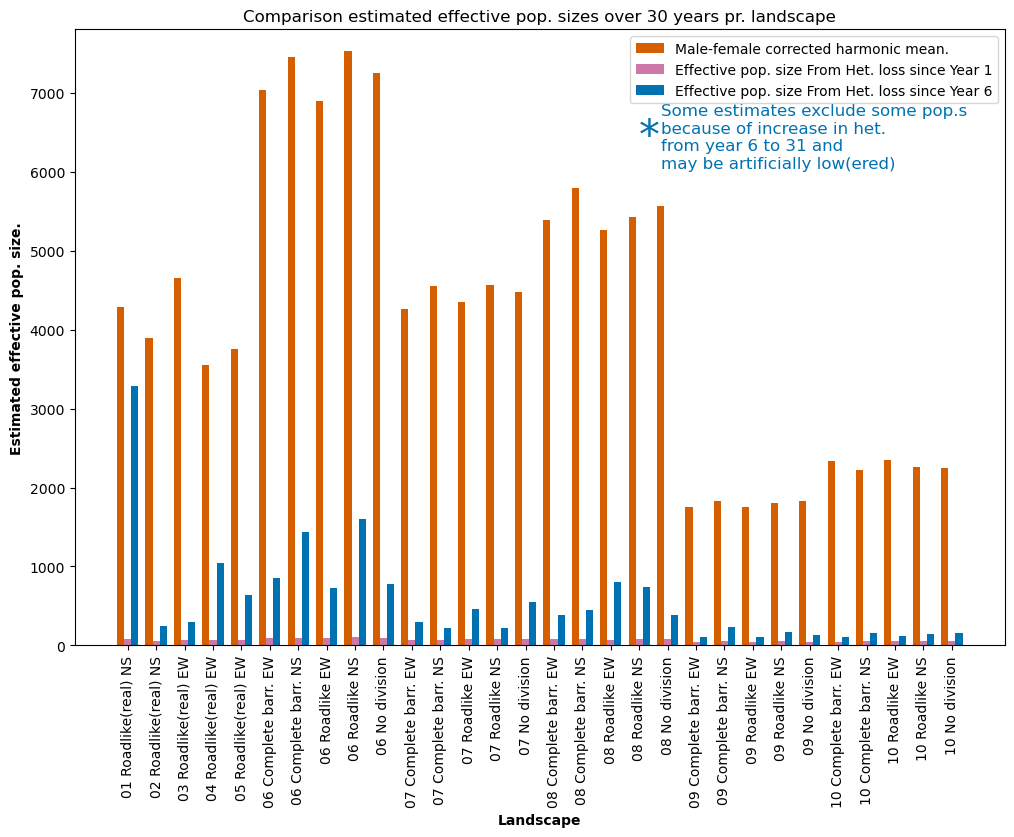

In [53]:
import pandas as pd
import matplotlib.pyplot as plt



# Group by 'landscape', and calculate the mean of each column
# Only including year 31 (end heterozyg.) and filtering out negative pop sizes (biases estimate but necessary)
df_grouped = df_het[(df_het['year']==31) & (df_het['estimated_pop_size_start6']>0)].groupby(['landscape','nice_labels']).mean(numeric_only=True).reset_index()

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))

# define bar width and positions
bar_width = 0.25
r1 = range(len(df_grouped))
r2 = [x + bar_width for x in r1] #making sure there's space for each bar
r3 = [x + bar_width for x in r2]

# plot bars
ax.bar(r1, df_grouped['mf_corrected_count'], color='#d55e00', width=bar_width, label='Male-female corrected harmonic mean.')
ax.bar(r2, df_grouped['estimated_pop_size1'], color='#cc79a7', width=bar_width, label='Effective pop. size From Het. loss since Year 1')
ax.bar(r3, df_grouped['estimated_pop_size_start6'], color='#0072b2', width=bar_width, label='Effective pop. size From Het. loss since Year 6')

# add x labels and title
ax.set_xlabel('Landscape', fontweight='bold')
ax.set_ylabel('Estimated effective pop. size.', fontweight='bold')
ax.set_title('Comparison estimated effective pop. sizes over 30 years pr. landscape')

# add xticks on the middle of the group bars
ax.set_xticks([r + bar_width for r in range(len(df_grouped))])
ax.set_xticklabels(df_grouped['nice_labels'], rotation=90)
ax.set_ylim(0,7800)

plt.text(18.25, 6300, '*', fontsize = 30, color='#0072b2')
#adding rebuttal :)
plt.text(19, 6050, 'Some estimates exclude some pop.s \nbecause of increase in het.\nfrom year 6 to 31 and\nmay be artificially low(ered)', fontsize = 12, color='#0072b2')

# Add legend
ax.legend()

# Show plot
plt.show()


_______
## FIS
* Merge with pop size estimate data set (here the previous estimate from equation) &#x2611;
* Filter FIS dataset to be only year 31 &#x2611;
* Put a "landscape_id", a "div_type", and "div_dir" (division direction) into the df &#x2611;
* Plot FIS for each div_type and div_dir, all landscapes together &#x2611;
* Plot FIS for each div_type and div_dir, each landcape alone. &#x2611;
* Plot FIS vs. pop size esitmate. &#x2611;

#### Filter to only have yeara 31, merge with an estimate of pop size

In [54]:
# first filter to only have end results :)
df_FIS=df_FIS[df_FIS['year']==31]
#unfortunately the best estimates we have are probably the estimated pop sizes until that year from year 1 and to current year (least unstable)
df_FIS = pd.merge(df_FIS, df_het[['landscape', 'pop', 'rep','year', 'estimated_pop_size1']], on=['landscape', 'pop', 'rep','year'], how='left')
df_FIS.head()

,year,pop,FIS,landscape,rep,estimated_pop_size1
0,31,0,0.337021,LS01_amNS,rep_0,87.185616
1,31,1,0.356761,LS01_amNS,rep_0,73.215320
2,31,2,0.499194,LS01_amNS,rep_0,50.396286
3,31,3,0.202393,LS01_amNS,rep_0,132.353990
4,31,0,0.390934,LS01_amNS,rep_1,65.839464


#### Extract and add characteristics of landscape

In [55]:
df_FIS['id_of_landscape'] = df_FIS['landscape'].str.extract(r'(\d{2})')
df_FIS['div_dir'] = df_FIS['landscape'].str[-2:]
df_FIS['div_type']= df_FIS['landscape'].str[-4:-2]
df_FIS.loc[df_FIS['div_dir'] == 'nm', 'div_type'] = 'nm'

df_FIS.tail()

,year,pop,FIS,landscape,rep,estimated_pop_size1,id_of_landscape,div_dir,div_type
1195,31,3,0.318812,LS10_nm,rep_8,89.139829,10,nm,nm
1196,31,0,0.588311,LS10_nm,rep_9,38.582448,10,nm,nm
1197,31,1,0.475481,LS10_nm,rep_9,50.643354,10,nm,nm
1198,31,2,0.382914,LS10_nm,rep_9,69.374073,10,nm,nm
1199,31,3,0.474017,LS10_nm,rep_9,49.754612,10,nm,nm


#### Plot FIS, all landscapes together
It does not look like there is much difference between the landscape types

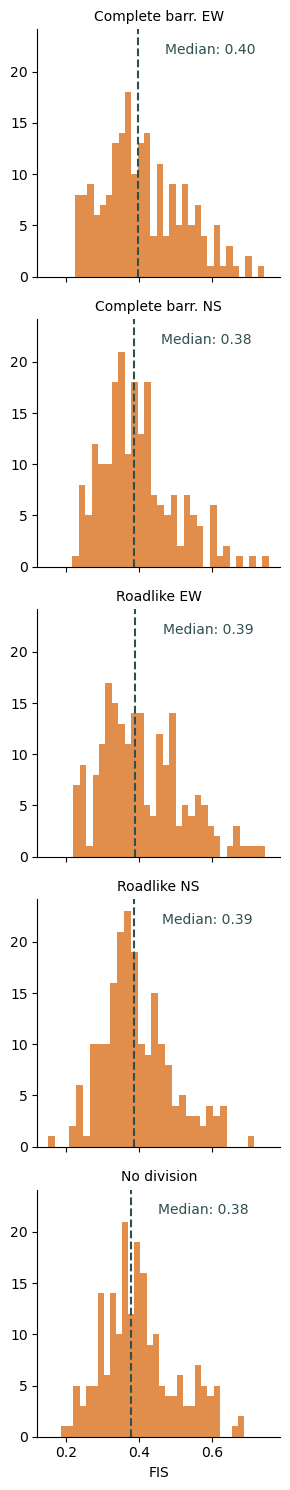

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt

# Mapping for degree of division to make sensible labels
degree_of_div_dict = {
    "nm": "No division", 
    "frNS": "Roadlike NS", 
    "fmNS": "Complete barr. NS", 
    "amNS": "Roadlike(real) NS",
    "frEW": "Roadlike EW", 
    "fmEW": "Complete barr. EW", 
    "amEW": "Roadlike(real) EW"
}

# Add degree_of_div column to dataframe
df_FIS['degree_of_div'] = df_FIS['landscape'].str[5:].map(degree_of_div_dict)

# Filter dataframe to not include the real roads
df_FIS_only_no_real_road = df_FIS[(df_FIS['degree_of_div'] != "Roadlike(real) NS") & 
                                  (df_FIS['degree_of_div'] != "Roadlike(real) EW")]

# Calculate median for each degree_of_div category
median_values = df_FIS_only_no_real_road.groupby('degree_of_div')['FIS'].median()

# Set up the FacetGrid
g = sns.FacetGrid(df_FIS_only_no_real_road, col='degree_of_div', margin_titles=True, col_wrap=1)
g.map(plt.hist, 'FIS', bins=30, color='#d55e00', alpha=0.7)

# Add median lines and annotations
for ax, div_category in zip(g.axes.flat, median_values.index):
    median = median_values[div_category]
    ax.axvline(median, color='darkslategray', linestyle='--')
    ax.text(median+0.2, ax.get_ylim()[1] * 0.9, f'Median: {median:.2f}', color='darkslategray', ha='center')

# Set titles for columns
g.set_titles(col_template="{col_name}")

# Show plot
plt.show()


#### Plot FIS, all landscapes on their own (not used)

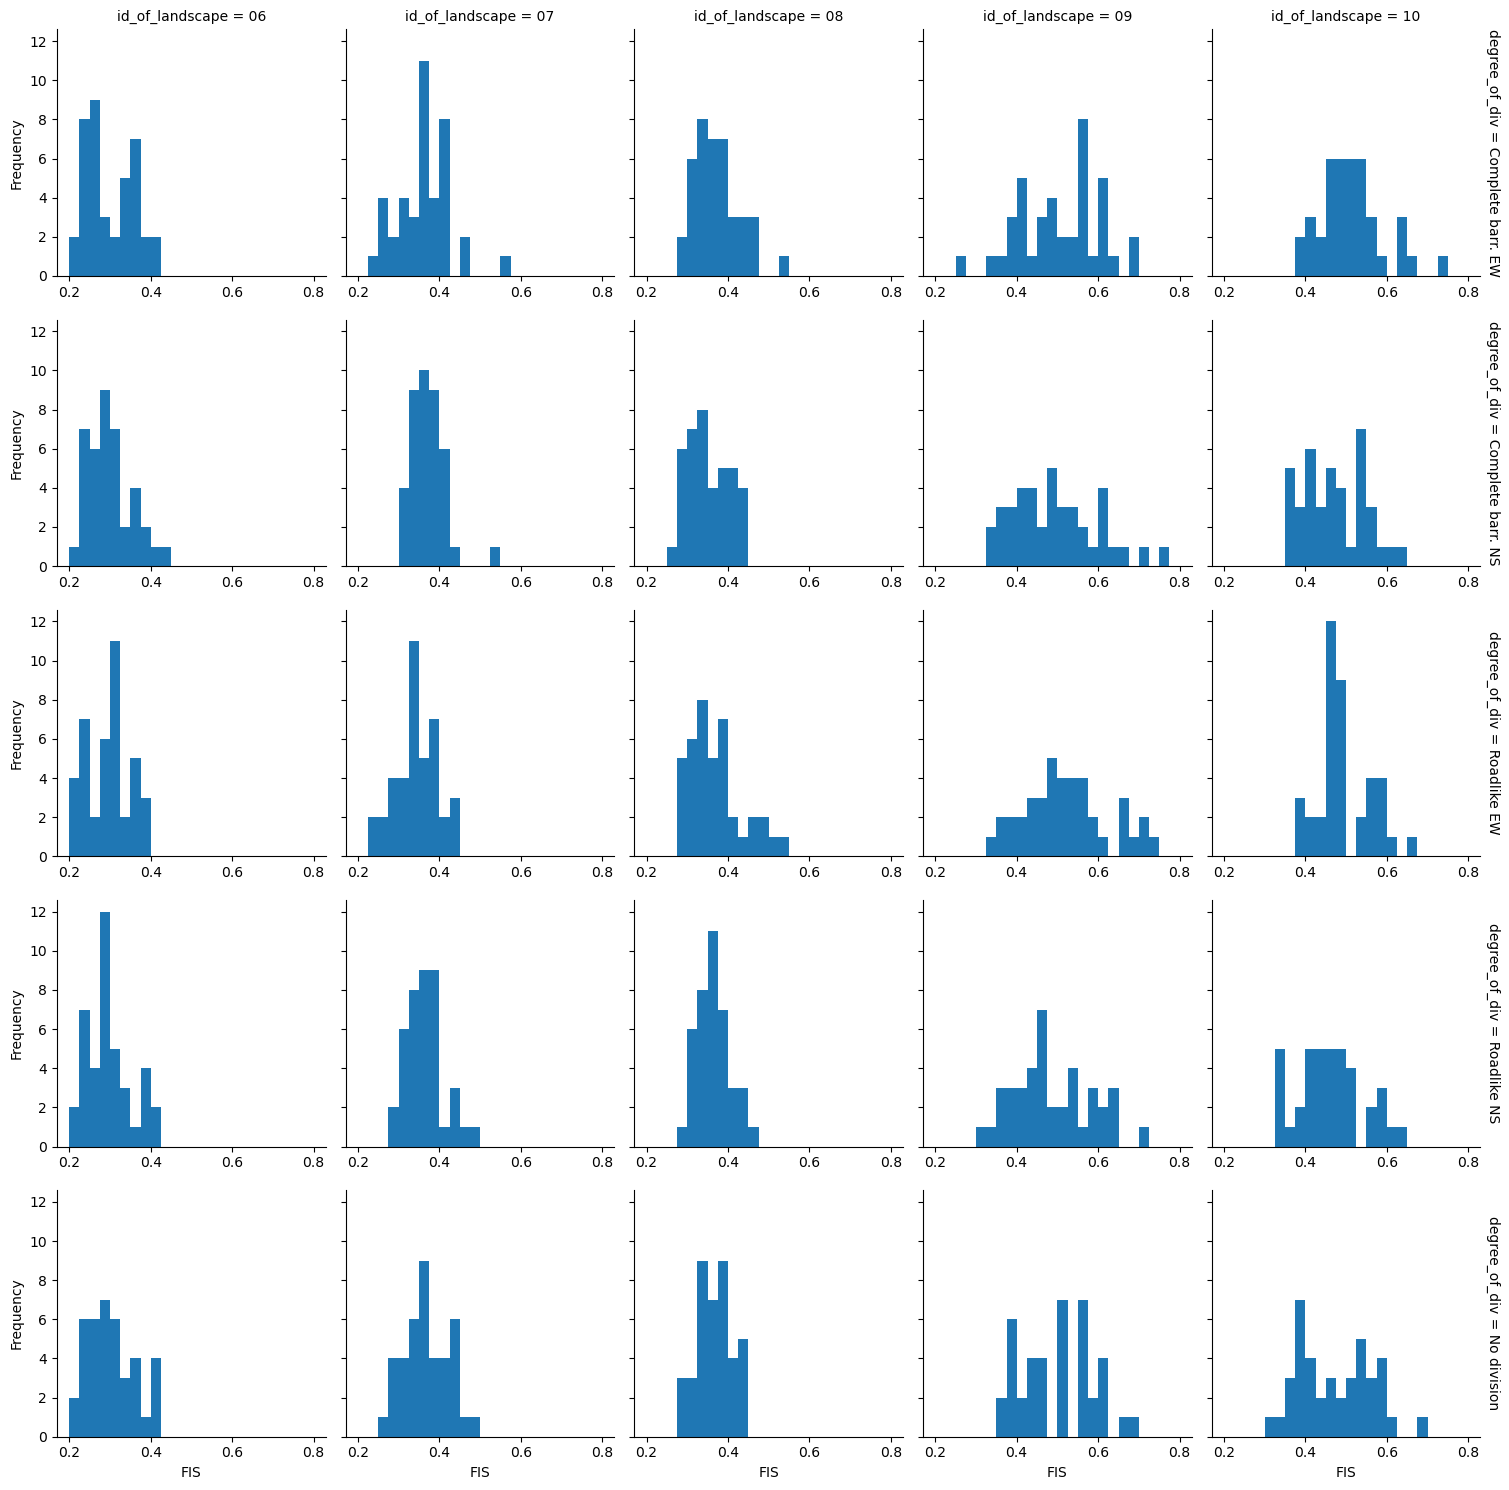

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Define the fixed bin width
bin_width = 0.025

# Calculate the bin edges based on the desired bin width
bin_edges = np.arange(0.2, 0.8 + bin_width, bin_width)

# Plot histograms in a grid
g = sns.FacetGrid(df_FIS_only_no_real_road, col='id_of_landscape', row='degree_of_div', margin_titles=True, sharex=False)
g.map(plt.hist, 'FIS', bins=bin_edges)

# Set axis labels for each subplot
g.set_axis_labels('FIS', 'Frequency')

plt.show()


#### Plot FIS vs. pop estimate (from het freq year 1)

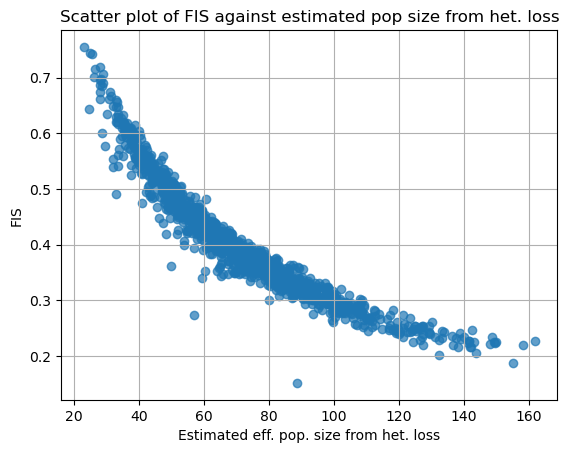

In [58]:
plt.scatter(df_FIS['estimated_pop_size1'], df_FIS['FIS'],alpha=0.7)
plt.xlabel('Estimated eff. pop. size from het. loss')
plt.ylabel('FIS')
plt.title('Scatter plot of FIS against estimated pop size from het. loss')
plt.grid(True)
plt.show()

_______________
## FST
* Filter FST dataset to be only year 31 &#x2611;
* Put a "landscape_id", a "div_type", and "div_dir" (division direction) into the  &#x2611;
* Filter out all comparisons to itself &#x2611;
* Keep just one version of comparison of a pair of populations ex. just 0 to 1 and not but 0 to 1 and 1 to 0. &#x2611;
* Put an "opposite" column: did the two pops come from the same or opposite side of division, if any? &#x2611;
* Plot FST for each div_type and div_dir, all landscapes together. &#x2611;
* Plot FST for each div_type and div_dir, each landcape alone.  &#x2611;

Filter to year 31

In [59]:
#filter FST dataset to year 31
df_FST=df_FST[df_FST['year']==31]
df_FST.head()

,year,pop0,pop1,FST,landscape,rep
480,31,0,0,0.000000,LS01_amNS,rep_0
481,31,0,1,0.022543,LS01_amNS,rep_0
482,31,0,2,0.019169,LS01_amNS,rep_0
483,31,0,3,0.013667,LS01_amNS,rep_0
484,31,1,0,0.022543,LS01_amNS,rep_0


Put the landscape division characteristics in

In [60]:
#again make nice labels for sensible labels in plotting
df_FST['id_of_landscape'] = df_FST['landscape'].str.extract(r'(\d{2})')
df_FST['div_dir'] = df_FST['landscape'].str[-2:]
df_FST['div_type']= df_FST['landscape'].str[-4:-2]
df_FST.loc[df_FST['div_dir'] == 'nm', 'div_type'] = 'nm'

degree_of_div_dict = {"nm": "No division", "frNS": "Roadlike NS", "fmNS": "Complete barr. NS","amNS":"Roadlike(real) NS","frEW": "Roadlike EW", "fmEW": "Complete barr. EW","amEW":"Roadlike(real) EW"}

df_FST['degree_of_div'] = df_FST['landscape'].str[5:].map(degree_of_div_dict)

df_FST.head()

,year,pop0,pop1,FST,landscape,rep,id_of_landscape,div_dir,div_type,degree_of_div
480,31,0,0,0.000000,LS01_amNS,rep_0,01,NS,am,Roadlike(real) NS
481,31,0,1,0.022543,LS01_amNS,rep_0,01,NS,am,Roadlike(real) NS
482,31,0,2,0.019169,LS01_amNS,rep_0,01,NS,am,Roadlike(real) NS
483,31,0,3,0.013667,LS01_amNS,rep_0,01,NS,am,Roadlike(real) NS
484,31,1,0,0.022543,LS01_amNS,rep_0,01,NS,am,Roadlike(real) NS


Filter out comparisons to itself + keep only 1 out of a pair of mutual comparisions

In [61]:
#removing comparisons to itself
df_FST=df_FST[df_FST['pop0']!=df_FST['pop1']]
print(len(df_FST))
#keep just one two of the comparisons of the two same populations
df_FST['pop_combined_sorted'] = df_FST[['pop0', 'pop1']].apply(lambda x: '_'.join(sorted(map(str, x))), axis=1)
df_FST= df_FST.drop_duplicates(subset=['year', 'landscape', 'pop_combined_sorted', 'rep'], keep='first')
print(len(df_FST))


3600
1800


#### Characterize if populations are on the same side of barrier

In [62]:
def determine_opposite_or_same(row): #only works for the 2*2 grid
    landscape = row['landscape']
    pop0 = row['pop0']
    pop1 = row['pop1']

    if landscape[-2:] == "NS":
        if pop0 % 2 == 0 and pop1 % 2 != 0 or pop1 % 2 == 0 and pop0 % 2 != 0:
            return "opposite"
        else: return "same"
    elif landscape[-2:]=="EW":
        if (pop0 > 1 and pop1 > 1) or (pop0 < 2 and pop1 < 2):
            return "same"
        else: return "opposite"
    else: return "no division"

df_FST['opposite'] = df_FST.apply(determine_opposite_or_same, axis=1)

#### Plotting FSTs based on division category and relative position to barrier

opposite
no division    0.019705
opposite       0.019097
same           0.019137
Name: FST, dtype: float64


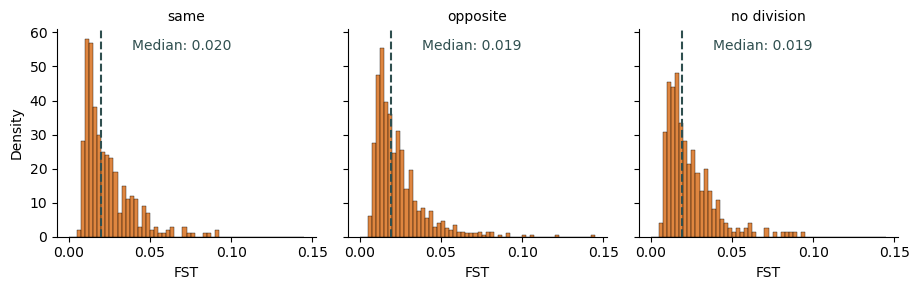

degree_of_div
Complete barr. EW    0.018553
Complete barr. NS    0.020219
No division          0.019705
Roadlike EW          0.019492
Roadlike NS          0.018435
Name: FST, dtype: float64


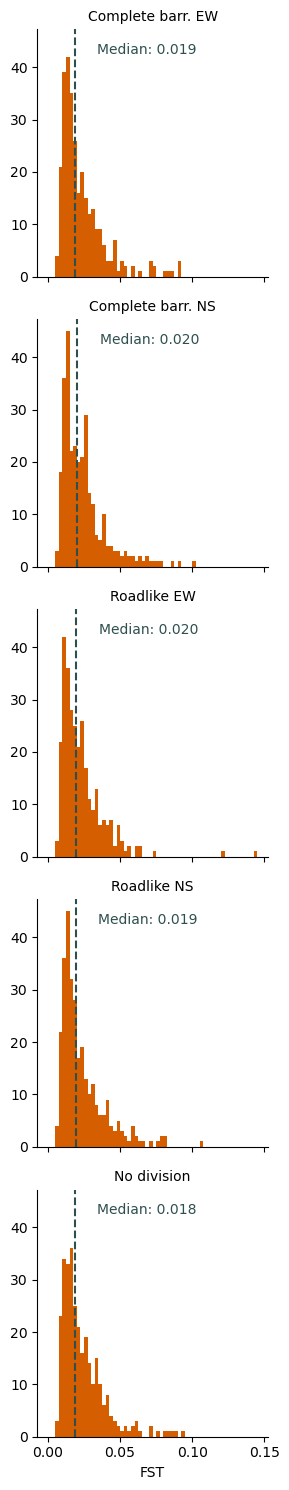

In [63]:
df_FST_only_no_real_road=df_FST[df_FST['degree_of_div']!="Roadlike(real) NS"]
df_FST_only_no_real_road=df_FST_only_no_real_road[df_FST_only_no_real_road['degree_of_div']!="Roadlike(real) EW"]
# Plot histograms

# Define the fixed bin width
bin_width = 0.0025

# Calculate the bin edges based on the desired bin width
bin_edges = np.arange(0.0, df_FST['FST'].max()+bin_width, bin_width)

median_values = df_FST_only_no_real_road.groupby('opposite')['FST'].median()
print(median_values)

g = sns.FacetGrid(df_FST_only_no_real_road, col='opposite', margin_titles=True, col_wrap=5) #um whats on the y axis??
g.map(sns.histplot, 'FST', bins=bin_edges, stat='density',color='#d55e00')
g.set_titles(col_template="{col_name}")

# Add median line to each subplot based on the calculated median values
for ax, div_category in zip(g.axes.flat, median_values.index):
    ax.axvline(median_values[div_category], color='darkslategray', linestyle='--')
    ax.text(median_values[div_category]+0.05, ax.get_ylim()[1] * 0.9, f'Median: {median_values[div_category]:.3f}', color='darkslategray', ha='center')

plt.show()

#
# Calculate median for each degree_of_div category
median_values = df_FST_only_no_real_road.groupby('degree_of_div')['FST'].median()
print(median_values)

# Plot histograms
g = sns.FacetGrid(df_FST_only_no_real_road, col='degree_of_div', margin_titles=True, col_wrap=1)
g.map(plt.hist, 'FST', bins=bin_edges, color='#d55e00')

# Add median line to each subplot based on the calculated median values
for ax, div_category in zip(g.axes.flat, median_values.index):
    ax.axvline(median_values[div_category], color='darkslategray', linestyle='--')
    ax.text(median_values[div_category]+0.05, ax.get_ylim()[1] * 0.9, f'Median: {median_values[div_category]:.3f}', color='darkslategray', ha='center')

g.set_titles(col_template="{col_name}")
plt.show()

_______________
## Distance and genetic similarity
* Classify all comparisons as either from the same or opposite side, or no div.
* Plot all landscapes together: x: distance, y: similarity, coulour by classification (same, opposite, no div)

Classify compared animals as coming from the same or opposite sides of divison, or having no division

In [64]:
df_simi['opposite'] = df_simi.apply(determine_opposite_or_same, axis=1)
df_simi['opposite'].unique()

array(['same', 'opposite', 'no division'], dtype=object)

In [65]:
degree_of_div_dict = {"nm": "No division", "frNS": "Roadlike NS", "fmNS": "Complete barr. NS","amNS":"Roadlike(real) NS","frEW": "Roadlike EW", "fmEW": "Complete barr. EW","amEW":"Roadlike(real) EW"}
df_simi['degree_of_div'] = df_simi['landscape'].str[5:].map(degree_of_div_dict)
df_simi[df_simi['opposite']=='no division']['degree_of_div'].head()

11227410    No division
11227411    No division
11227412    No division
11227413    No division
11227414    No division
Name: degree_of_div, dtype: object

### Plot distance for categories agains genetic similarity

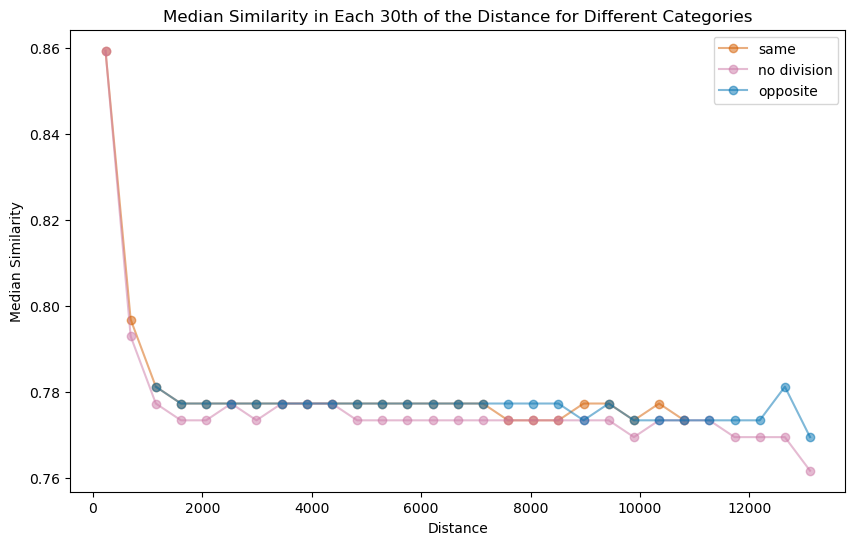

In [68]:
import numpy as np


# Create intervals for the x-axis
interval_width = (df_simi['distance'].max() - df_simi['distance'].min()) / 30
intervals = np.arange(df_simi['distance'].min(), df_simi['distance'].max(), interval_width)
midpoints = intervals[:-1] + interval_width / 2

# Initialize a figure and axis
plt.figure(figsize=(10, 6))

# Categories to plot
categories = ['same','no division', 'opposite']
colors = ['#d55e00', '#cc79a7', '#0072b2']

for category, color in zip(categories, colors):
    # Filter data for the current category
    subset = df_simi[df_simi['opposite'] == category]
    
    # Calculate median similarity for each interval
    medians = []
    for j in range(len(intervals) - 1):
        interval_subset = subset[(subset['distance'] >= intervals[j]) & (subset['distance'] < intervals[j+1])]
        median = interval_subset['similarity'].median()
        medians.append(median)
    
    # Plot the medians
    plt.plot(midpoints, medians, marker='o', linestyle='-', label=category, color=color, alpha=0.5)

# Add labels and title
plt.xlabel('Distance')
plt.ylabel('Median Similarity')
plt.title('Median Similarity in Each 30th of the Distance for Different Categories')
plt.legend()

# Show the plot
plt.show()
